In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
def load_data():
    df = pd.read_csv('../data/SeoulBikeData.csv', encoding='latin1')
    df.columns = df.columns.str.strip()
    df = df.rename(columns={
        'Date': 'date',
        'Rented Bike Count': 'rented_bike_count',
        'Hour': 'hour',
        'Temperature(°C)': 'temperature_c',
        'Humidity(%)': 'humidity',
        'Wind speed (m/s)': 'wind_speed',
        'Visibility (10m)': 'visibility_10m',
        'Dew point temperature(°C)': 'dew_point_c',
        'Solar Radiation (MJ/m2)': 'solar_radiation',
        'Rainfall(mm)': 'rainfall_mm',
        'Snowfall (cm)': 'snowfall_cm',
        'Seasons': 'season',
        'Holiday': 'holiday',
        'Functioning Day': 'functioning_day'
    })
    
    return df

In [3]:
df = load_data()
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (8760, 14)


,date,rented_bike_count,hour,temperature_c,humidity,wind_speed,visibility_10m,dew_point_c,solar_radiation,rainfall_mm,snowfall_cm,season,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               8760 non-null   object 
 1   rented_bike_count  8760 non-null   int64  
 2   hour               8760 non-null   int64  
 3   temperature_c      8760 non-null   float64
 4   humidity           8760 non-null   int64  
 5   wind_speed         8760 non-null   float64
 6   visibility_10m     8760 non-null   int64  
 7   dew_point_c        8760 non-null   float64
 8   solar_radiation    8760 non-null   float64
 9   rainfall_mm        8760 non-null   float64
 10  snowfall_cm        8760 non-null   float64
 11  season             8760 non-null   object 
 12  holiday            8760 non-null   object 
 13  functioning_day    8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB
None


In [5]:
print("\nTarget variable statistics:")
print(df['rented_bike_count'].describe())


Target variable statistics:
count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: rented_bike_count, dtype: float64


In [6]:
df.isnull().sum()

date                 0
rented_bike_count    0
hour                 0
temperature_c        0
humidity             0
wind_speed           0
visibility_10m       0
dew_point_c          0
solar_radiation      0
rainfall_mm          0
snowfall_cm          0
season               0
holiday              0
functioning_day      0
dtype: int64

In [7]:
def feature_engineering(df):
    df = df.copy()
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    
    # Extract datetime features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_name'] = df['date'].dt.day_name()
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Cyclical features for time
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    df['time_of_day'] = pd.cut(df['hour'], 
                               bins=[0, 6, 12, 18, 24], 
                               labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                               include_lowest=True)
    
    df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
    
    df['temp_feel'] = pd.cut(df['temperature_c'], 
                            bins=[-float('inf'), 0, 10, 20, float('inf')],
                            labels=['Very_Cold', 'Cold', 'Mild', 'Warm'])
    
    # Weather interactions
    df['temp_humidity_interaction'] = df['temperature_c'] * df['humidity'] / 100
    df['wind_rain_interaction'] = df['wind_speed'] * df['rainfall_mm']
    df['temp_solar_interaction'] = df['temperature_c'] * df['solar_radiation']
    
    # Binary weather conditions
    df['has_rain'] = (df['rainfall_mm'] > 0).astype(int)
    df['has_snow'] = (df['snowfall_cm'] > 0).astype(int)
    df['is_holiday'] = (df['holiday'] == 'Holiday').astype(int)
    df['is_functioning'] = (df['functioning_day'] == 'Yes').astype(int)
    
    # Seasonal indicators
    df['is_spring'] = (df['season'] == 'Spring').astype(int)
    df['is_summer'] = (df['season'] == 'Summer').astype(int)
    df['is_autumn'] = (df['season'] == 'Autumn').astype(int)
    df['is_winter'] = (df['season'] == 'Winter').astype(int)
    
    # Weather severity
    df['extreme_weather'] = ((df['rainfall_mm'] > 5) | 
                            (df['snowfall_cm'] > 1) | 
                            (df['wind_speed'] > 5)).astype(int)
    
    return df

In [8]:
df_features = feature_engineering(df)
print(f"Dataset shape after feature engineering: {df_features.shape}")

Dataset shape after feature engineering: (8760, 41)


In [9]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       8760 non-null   datetime64[ns]
 1   rented_bike_count          8760 non-null   int64         
 2   hour                       8760 non-null   int64         
 3   temperature_c              8760 non-null   float64       
 4   humidity                   8760 non-null   int64         
 5   wind_speed                 8760 non-null   float64       
 6   visibility_10m             8760 non-null   int64         
 7   dew_point_c                8760 non-null   float64       
 8   solar_radiation            8760 non-null   float64       
 9   rainfall_mm                8760 non-null   float64       
 10  snowfall_cm                8760 non-null   float64       
 11  season                     8760 non-null   object        
 12  holida

In [10]:
def prepare_features(df):
    """Prepare features for machine learning models"""
    
    numerical_features = [
        'hour', 'temperature_c', 'humidity', 'wind_speed', 'visibility_10m',
        'dew_point_c', 'solar_radiation', 'rainfall_mm', 'snowfall_cm',
        'year', 'month', 'day_of_week', 'hour_sin', 'hour_cos',
        'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
        'temp_humidity_interaction', 'wind_rain_interaction', 'temp_solar_interaction'
    ]

    binary_features = [
        'is_weekend', 'is_rush_hour', 'has_rain', 'has_snow', 
        'is_holiday', 'is_functioning', 'is_spring', 'is_summer', 
        'is_autumn', 'is_winter', 'extreme_weather'
    ]
    categorical_features = ['time_of_day', 'temp_feel']
    df_encoded=pd.get_dummies(df,columns=categorical_features,prefix=categorical_features)
    encoded_categorical_cols = [col for col in df_encoded.columns 
                               if any(cat in col for cat in categorical_features)]

    all_features = numerical_features + binary_features + encoded_categorical_cols
    
    X = df_encoded[all_features]
    y = df_encoded['rented_bike_count']
    return X,y,all_features
    

In [11]:
# Prepare features
X, y, feature_names = prepare_features(df_features)
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Number of features: {len(feature_names)}")

# %%
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5)
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training target range: {y_train.min():.0f} - {y_train.max():.0f}")
print(f"Test target range: {y_test.min():.0f} - {y_test.max():.0f}")

Feature matrix shape: (8760, 40)
Target variable shape: (8760,)
Number of features: 40
Training set size: 7008
Test set size: 1752
Training target range: 0 - 3556
Test target range: 0 - 3384


In [12]:
# Model evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate a model and return comprehensive metrics"""
    # Fit the model
    model.fit(X_train,y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    # Calculate MAPE (Mean Absolute Percentage Error)
    def mape(actual, predicted):
        return np.mean(np.abs((actual - predicted) / actual))*100

    train_mape = mape(y_train, y_pred_train)
    test_mape = mape(y_test, y_pred_test)
    return {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Overfitting_Score': train_rmse - test_rmse
    }
    

In [13]:
def get_models():
    """Get dictionary of models to evaluate"""
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0, random_state=42),
        'Lasso Regression': Lasso(alpha=1.0, random_state=42),
        'Elastic Net': ElasticNet(alpha=1.0, random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=15),
        'Random Forest': RandomForestRegressor(
            n_estimators=100, random_state=42, max_depth=15, n_jobs=-1
        ),
        'Extra Trees': ExtraTreesRegressor(
            n_estimators=100, random_state=42, max_depth=15, n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100, random_state=42, max_depth=6
        ),
        'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
        'Support Vector Regression': SVR(kernel='rbf', C=100, gamma='scale')
    }
    return models

In [20]:
def train_all_models(X_train, X_test, y_train, y_test):
    """Train and evaluate all models"""
    models = get_models()
    results = []
    trained_models = {}
    
    # Scale features for models that need it
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    scale_sensitive_models = ['Linear Regression', 'Ridge Regression', 
                             'Lasso Regression', 'Elastic Net', 
                             'K-Nearest Neighbors', 'Support Vector Regression']
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        if name in scale_sensitive_models:
            # Use scaled features
            result = evaluate_model(model, X_train_scaled, X_test_scaled, 
                                  y_train, y_test, name)
            model.fit(X_train_scaled, y_train)
        else:
            # Use original features
            result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
            model.fit(X_train, y_train)
        
        results.append(result)
        trained_models[name] = model
    
    return pd.DataFrame(results), trained_models, scaler

# Train all models
results_df, trained_models, scaler = train_all_models(X_train, X_test, y_train, y_test)

Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training Elastic Net...
Training Decision Tree...
Training Random Forest...
Training Extra Trees...
Training Gradient Boosting...
Training K-Nearest Neighbors...
Training Support Vector Regression...


In [25]:
print("Model Performance Comparison:")
print("*"*80)
results_display = results_df.round(3)
print(results_display.to_string(index=False))

Model Performance Comparison:
********************************************************************************
                    Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  Train_MAPE  Test_MAPE  Overfitting_Score
        Linear Regression     348.603    348.390    260.715   255.732     0.708    0.708         inf        inf              0.212
         Ridge Regression     348.603    348.418    260.712   255.766     0.708    0.708         inf        inf              0.185
         Lasso Regression     349.086    348.924    260.591   256.233     0.707    0.707         inf        inf              0.161
              Elastic Net     391.195    391.799    287.383   285.056     0.632    0.631         inf        inf             -0.604
            Decision Tree      81.123    236.840     33.811   132.688     0.984    0.865        4.64        inf           -155.718
            Random Forest      75.133    166.309     45.163    97.807     0.986    0.934         inf   

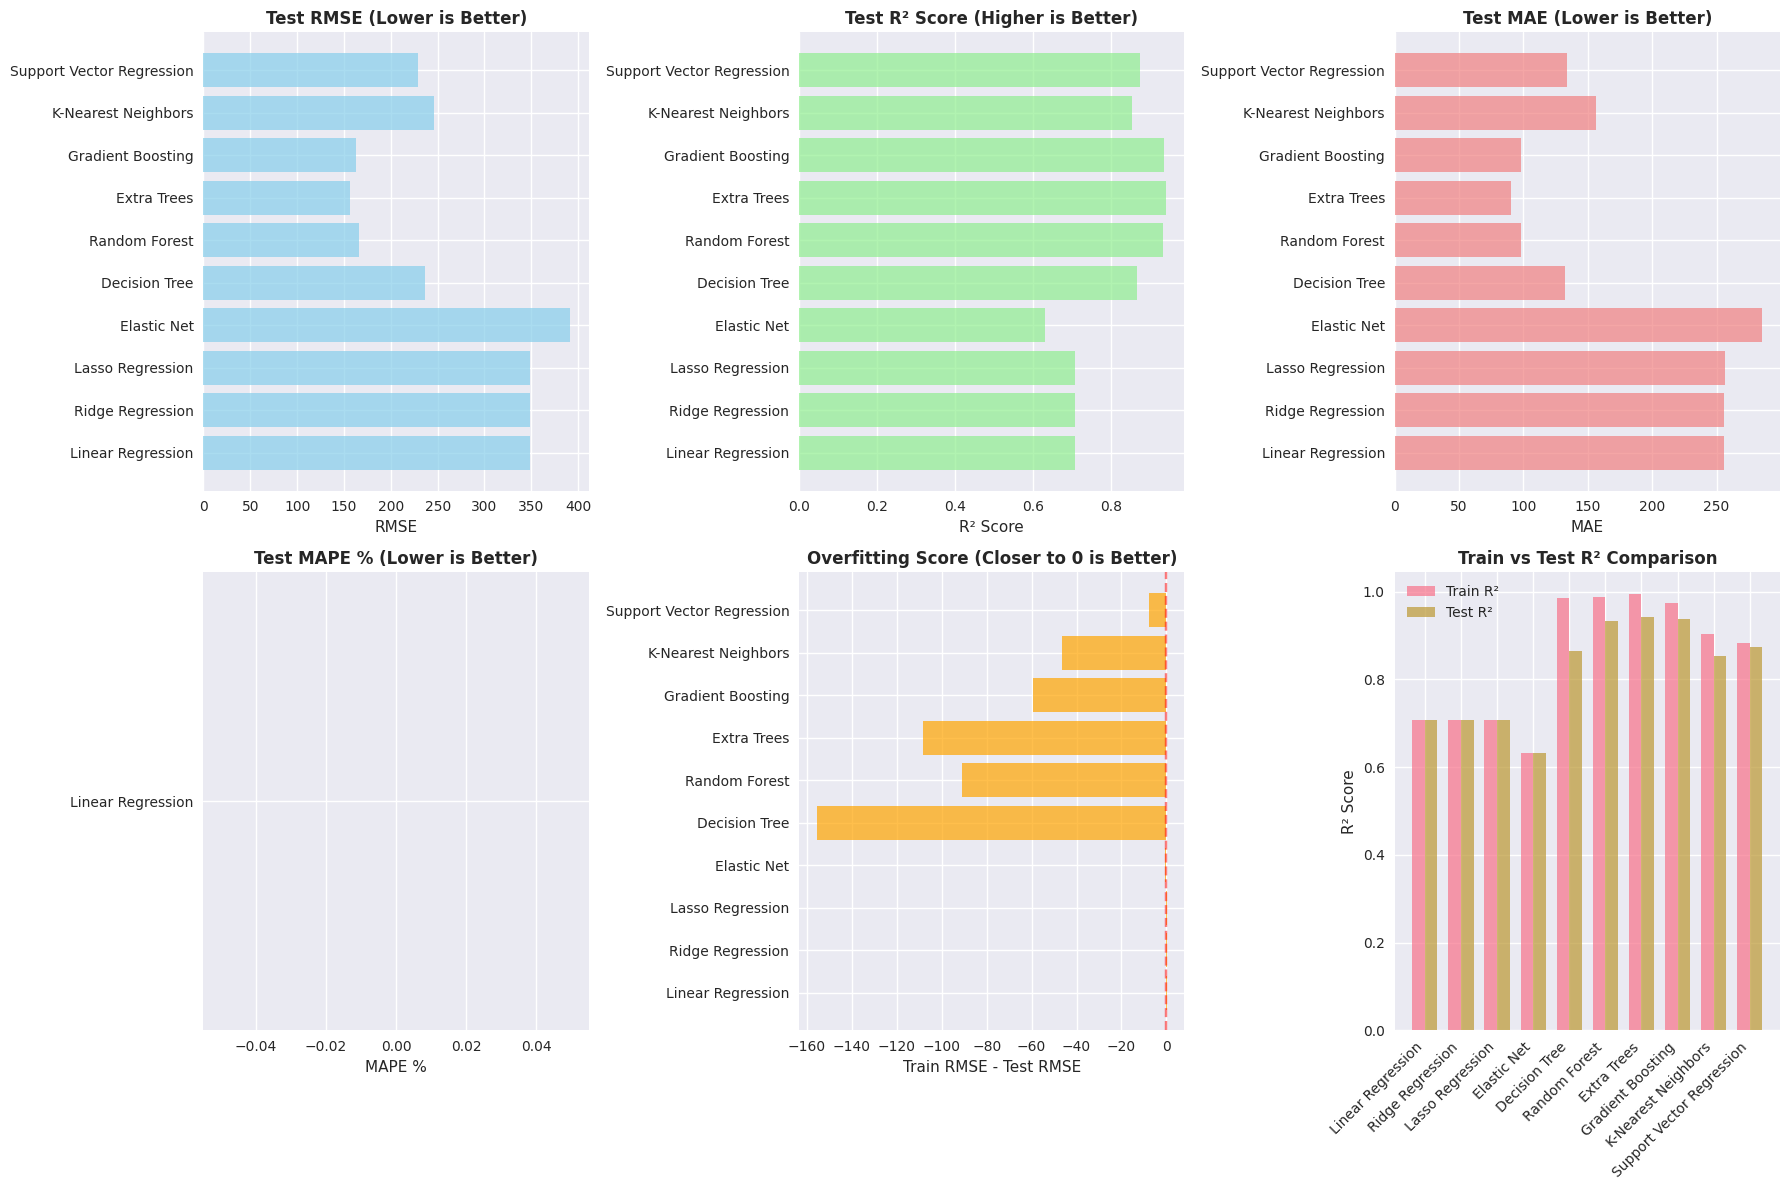

In [56]:
def plot_model_comparison(results_df):
    """Create comprehensive model comparison plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Test RMSE
    axes[0, 0].barh(results_df['Model'], results_df['Test_RMSE'], color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Test RMSE (Lower is Better)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('RMSE')
    
    # Test R²
    axes[0, 1].barh(results_df['Model'], results_df['Test_R2'], color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Test R² Score (Higher is Better)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('R² Score')
    
    # Test MAE
    axes[0, 2].barh(results_df['Model'], results_df['Test_MAE'], color='lightcoral', alpha=0.7)
    axes[0, 2].set_title('Test MAE (Lower is Better)', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('MAE')
    
    # Test MAPE
    axes[1, 0].barh(results_df['Model'], results_df['Test_MAPE'], color='gold', alpha=0.7)
    axes[1, 0].set_title('Test MAPE % (Lower is Better)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('MAPE %')
    
    # Overfitting analysis
    axes[1, 1].barh(results_df['Model'], results_df['Overfitting_Score'], color='orange', alpha=0.7)
    axes[1, 1].set_title('Overfitting Score (Closer to 0 is Better)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Train RMSE - Test RMSE')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
    
    # Train vs Test R² comparison
    x = np.arange(len(results_df))
    width = 0.35
    axes[1, 2].bar(x - width/2, results_df['Train_R2'], width, label='Train R²', alpha=0.7)
    axes[1, 2].bar(x + width/2, results_df['Test_R2'], width, label='Test R²', alpha=0.7)
    axes[1, 2].set_title('Train vs Test R² Comparison', fontsize=12, fontweight='bold')
    axes[1, 2].set_ylabel('R² Score')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

plot_model_comparison(results_df)

In [66]:
# Find best models
print("Top 3 Models by Test R² Score:")
print("*"*50)
top_models=results_df.nlargest(3,'Test_R2')[['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE']]
print(top_models.to_string(index=False))
best_model_name=results_df.loc[results_df['Test_R2'].idxmax(),'Model']
print("*"*50)
print(f"Best performing model: {best_model_name}")

Top 3 Models by Test R² Score:
**************************************************
            Model  Test_R2  Test_RMSE  Test_MAE
      Extra Trees 0.940850 156.860274 90.229499
Gradient Boosting 0.936594 162.405486 97.916283
    Random Forest 0.933509 166.308666 97.806935
**************************************************
Best performing model: Extra Trees
